<h1>Problem</h1>

A supplier is shipping N different parts to Tesla.
 
Every part has a known (deterministic) demand every day.  That is, we know how many parts we will need to build the cars scheduled for production that day.
 
Each part comes in a box with a certain given quantity, and a certain known volume for the box.
 
Parts are delivered in trucks. The truck cost is essentially fixed per truck, that is regardless of whether a truck is half full or completely full the cost is the same. For simplicity, we can model the truck has having a known max volume capacity, and the sum of the volumes of the parts in the truck has to be less than this capacity. (Obviously this is a simplification, in reality fitting the most number of boxes in a truck is a more complex problem)
 
Unused parts from one day carry forward to the next day. We must never run out of a part completely, but other than that generally less inventory is preferred over more.
 
Questions.
1.       Formulate as a Mixed Integer Program the problem of ordering the right number of parts and scheduling the right number of trucks.
2.       Discuss what are the key tradeoffs in this problem and how will different parameters influence the nature of the optimal solution.

<h1>Solution</h1>

**Assumptions**

- Ample storage space is already contracted: instead of minimizing long-term rent costs, we want to minimize spaced used by these parts in the short term

**Data**

h<sub>N,0</sub> = <em>"init_stock"</em> = initial stock of part N 

d<sub>N,D</sub> = <em>"daily_demand"</em> = demand of part N on day D

v<sub>T</sub> = <em>"truck_vol"</em> = volume of truck (cubic ft)

q<sub>N</sub> = <em>"box_qty"</em> = qty of box of part N

v<sub>N</sub> = <em>"box_vol"</em> = vol of box of part N (cubic ft)

c<sub>D</sub> = <em>"load_cost"</em> = shipping cost for a 53-ft truck that arrives on day D

w<sub>N</sub> = <em>"storage_cost"</em> = nightly cost of holding one box of part N

**Decision Variables**

x<sub>N,D</sub> = <em>"boxes_arriving"</em> = boxes of part N arriving on day D

t<sub>D</sub> = <em>"trucks_arriving"</em> = amount of trucks arriving on day D

h<sub>N,D</sub> = <em>"qty_held" </em>= qty of part N held overnight from day D to D+1

**Objective Function**

__min__ $\sum_{D=1}^{7} (c_D * t_D) + \sum_{D=1}^{7} \sum_{N=0}^{19} (w_N*h_{N,D})$

_ (cost of trucks) + (cost of holding material)_

**Constraints**

Conserve inventory: $h_{N,D}=h_{N,D-1} + (x_{N,D}*q_N) - d_{N,D} \forall  D \in {1,...,7}, N \in {0,...,11} $

_parts held overnight = previously held parts + parts arriving - part demand for the day_

Required truck capacity: $t_D*v_T\geq \sum_{N=0}^{19} x_{N,D}*v_N \forall D \in {1,...,7}$

_trucks arriving on a day * volume of a truck >= combined volume of all parts arriving on that day_

Meet daily demand: $x_{N,D}*q_N + h_{N,D-1} \geq d_{N,D} \forall D \in {1,...,7}, N \in {0,...,11}$

_parts arriving + previously held parts >= part demand for the day_

$x_{N,D } \geq 0 \forall D \in {1,...,7}, N \in {0,...,11}$

$t_{D } \geq 0 \forall D \in {1,...,7}, N \in {0,...,11}$

$h_{N,D} \geq 0 \forall D \in {1,...,7}, N \in {0,...,11}$


In [1]:
import numpy as np
from numpy import *
from gurobipy import *
import pandas as pd

In [2]:
#populate N parts
N = 12
parts = [] 
for part in range(N):
    parts.append(part)
print(parts)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [3]:
#plan for the next D days (day 0 is the initial day)
D = 7
days = []
for day in range(1,D+1):
    days.append(day)
print(days)

[1, 2, 3, 4, 5, 6, 7]


In [4]:
#Deterministic data (demand and initial values) import from static excel file 
deterministic_data_filepath = 'DeterministicDemand.xlsx'
demand_data = pd.read_excel(deterministic_data_filepath).fillna(0)

print(demand_data.head())

   Part  Day 0 Stock  Day 1 Demand  Day 2 Demand  Day 3 Demand  Day 4 Demand  \
0     0          250         100.0         100.0         100.0         100.0   
1     1          400           0.0         250.0           0.0         250.0   
2     2          350          50.0         100.0          50.0         100.0   
3     3          250           0.0           0.0         300.0           0.0   
4     4           75           0.0          25.0          25.0          25.0   

   Day 5 Demand  Day 6 Demand  Day 7 Demand  
0         100.0         100.0         100.0  
1           0.0         250.0           0.0  
2          50.0         100.0          50.0  
3         300.0           0.0           0.0  
4          25.0          25.0           0.0  


In [5]:
#populate initial stock of parts
init_stock = list(demand_data['Day 0 Stock']) #get values from deterministic table
#init_stock = [] 

#for part in parts: #define from a uniform random qty: 1-100
    #init_stock.append(np.random.randint(0,high=250)) 
    
print(init_stock)
demand_data = demand_data.drop(columns=['Part', 'Day 0 Stock']) #drop deterministic init values, leaving only demand

[250, 400, 350, 250, 75, 10, 5, 200, 50, 24, 10, 200]


In [6]:
#define daily demands per part for the next 7 days (imported from a csv file )
daily_demand = []
for part in parts:
    part_dem = demand_data.values[part].tolist()
    day_demand = [None]
    for dem in part_dem:
        day_demand.append(dem)
    print("Part " + str(part) + ": " + str(day_demand))
    daily_demand.append(day_demand)

Part 0: [None, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Part 1: [None, 0.0, 250.0, 0.0, 250.0, 0.0, 250.0, 0.0]
Part 2: [None, 50.0, 100.0, 50.0, 100.0, 50.0, 100.0, 50.0]
Part 3: [None, 0.0, 0.0, 300.0, 0.0, 300.0, 0.0, 0.0]
Part 4: [None, 0.0, 25.0, 25.0, 25.0, 25.0, 25.0, 0.0]
Part 5: [None, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Part 6: [None, 25.0, 50.0, 50.0, 50.0, 50.0, 50.0, 25.0]
Part 7: [None, 0.0, 150.0, 0.0, 150.0, 0.0, 250.0, 0.0]
Part 8: [None, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
Part 9: [None, 0.0, 12.0, 24.0, 12.0, 24.0, 12.0, 0.0]
Part 10: [None, 5.0, 10.0, 10.0, 10.0, 50.0, 10.0, 5.0]
Part 11: [None, 0.0, 0.0, 0.0, 0.0, 350.0, 0.0, 0.0]


In [7]:
#define truck volume (cubic feet)
truck_vol = 3489

In [8]:
#define quantity per box of part N
box_qty = []
for part in parts:
    box_qty.append(np.random.choice([2,5,10,12,25]))
print(box_qty)

[25, 12, 10, 5, 5, 25, 5, 2, 12, 5, 12, 2]


In [9]:
#define box volume of part N (cubic feet)
box_vol = []
for part in parts:
    box_vol.append(np.random.randint(3.48,high=348)) #max box vol capped to 1/10 of truck size
print(box_vol)

[41, 135, 326, 283, 344, 42, 144, 330, 216, 104, 171, 291]


In [20]:
#define cost per truck arriving day D
load_cost = [None]
for day in days:
    #load_cost.append(np.random.randint(2500,high=5000)) #uniform between $2.5k-$5k
    load_cost.append(3000)
print(load_cost)

[None, 3000, 3000, 3000, 3000, 3000, 3000, 3000]


In [13]:
#nightly storage costs for a box of part N
storage_cost = []
for part in parts:
    box_storage_cost = box_vol[part]*0.1789
    piece_storage_cost = box_storage_cost / box_qty[part]
    storage_cost.append(piece_storage_cost) #assume yearly sq ft cost to be $6.50 ($0.1789/night/sqft)
print(storage_cost)

[0.29339599999999999, 2.0126250000000003, 5.8321400000000008, 10.12574, 12.30832, 0.30055199999999999, 5.1523200000000005, 29.5185, 3.2202000000000002, 3.72112, 2.5493250000000001, 26.029949999999999]


In [21]:
m = Model("ConnerTesla")

#decision variables
boxes_arriving = m.addVars(parts,days,name="x",vtype=GRB.INTEGER) #boxes of part N to arrive on day D
trucks_arriving = m.addVars(days,name="t",vtype=GRB.INTEGER) #trucks arriving on day D
qty_held = m.addVars(parts,days,name="h",vtype=GRB.INTEGER) #qty of part N stored from day D to D+1

#objective function
total_trucking_cost = sum(load_cost[d] * trucks_arriving[d] for d in days)
total_holding_cost = sum(storage_cost[day]*qty_held[part,day] for part in parts for day in days)
total_cost = total_trucking_cost + total_holding_cost

m.setObjective(total_cost, GRB.MINIMIZE)

#constraints

for n in parts:
    for d in days:
        if d == 1: #use init stock for the first day
            
            #conserve inventory constraint
            m.addConstr(qty_held[n,d] == init_stock[n] + (boxes_arriving[n,d]*box_qty[n]) - daily_demand[n][d])
            
            #meet daily demand constraint
            m.addConstr(init_stock[n]+(boxes_arriving[n,d]*box_qty[n]) >= daily_demand[n][d])
            
        else: #use previous holdings otherwise
            
            #conserve inventory constraint
            m.addConstr(qty_held[n,d] == qty_held[n,(d-1)] + (boxes_arriving[n,d]*box_qty[n]) - daily_demand[n][d])
            
            #meet daily demand constraint
            m.addConstr(qty_held[n,(d-1)]+(boxes_arriving[n,d]*box_qty[n]) >= daily_demand[n][d])


for d in days:
    #required truck capacity constraint
    m.addConstr(trucks_arriving[d] * truck_vol >= sum((boxes_arriving[n,d]*box_vol[n]) for n in parts))
    m.addConstr(trucks_arriving[d]>=0)
    
for n in parts:
    for d in days:
        m.addConstr(qty_held[n,d]>=0)
        m.addConstr(boxes_arriving[n,d]>=0)
        
m.optimize()

Optimize a model with 350 rows, 175 columns and 662 nonzeros
Variable types: 0 continuous, 175 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [3e-01, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 4e+02]
Found heuristic solution: objective 148080.78361
Presolve removed 308 rows and 93 columns
Presolve time: 0.00s
Presolved: 42 rows, 82 columns, 205 nonzeros
Variable types: 0 continuous, 82 integer (1 binary)

Root relaxation: objective 1.270893e+05, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 127089.310    0    8 148080.784 127089.310  14.2%     -    0s
H    0     0                    133216.89687 127089.310  4.60%     -    0s
H    0     0                    133090.35195 127089.310  4.51%     -    0s
H    0     0                    131633.97178 127089.310  3.45%     -   

In [22]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

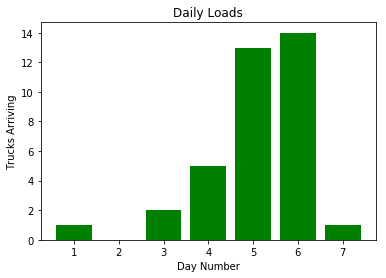

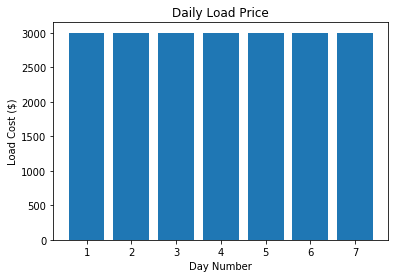

In [23]:
import matplotlib.pyplot as plt
truck_plan = []
truck_cost = []
for d in days:
    truck_plan.append(trucks_arriving[d].X)
    truck_cost.append(load_cost[d])
plt.bar(days,truck_plan,color = 'green')
plt.title('Daily Loads')
plt.ylabel('Trucks Arriving')
plt.xlabel('Day Number')
plt.show()

plt.bar(days,truck_cost)
plt.title('Daily Load Price')
plt.ylabel('Load Cost ($)')
plt.xlabel('Day Number')
plt.show()

In [24]:
parts_plan = []
for n in parts:
    part_plan = [init_stock[n]]
    for d in days:
        part_plan.append(boxes_arriving[n,d].X*box_qty[n])
    parts_plan.append(part_plan)

partsplan = pd.DataFrame(parts_plan)

holding_plan = []
for n in parts:
    part_holding = []
    for d in days:
        part_holding.append(qty_held[n,d].X)
    holding_plan.append(part_holding)

holdingplan = pd.DataFrame(holding_plan)

display_side_by_side(partsplan,pd.DataFrame(daily_demand))

,0,1,2,3,4,5,6,7
0,250,-0.0,-0.0,50.0,100.0,100.0,100.0,100.0
1,400,-0.0,-0.0,-0.0,108.0,-0.0,252.0,-0.0
2,350,-0.0,-0.0,-0.0,-0.0,-0.0,100.0,50.0
3,250,-0.0,0.0,50.0,-0.0,300.0,-0.0,-0.0
4,75,-0.0,-0.0,-0.0,-0.0,25.0,25.0,-0.0
5,10,50.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
6,5,70.0,0.0,50.0,50.0,50.0,50.0,25.0
7,200,6.0,-0.0,12.0,86.0,12.0,234.0,-0.0
8,50,-0.0,-0.0,-0.0,-0.0,-0.0,12.0,12.0
9,24,-0.0,-0.0,15.0,10.0,25.0,10.0,-0.0
